In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
import logging
from pyspark.sql.functions import col, sum as pyspark_sum, countDistinct
from pyspark.sql.functions import to_timestamp
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import numpy as np
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, unix_timestamp, hour, dayofmonth, month, year, to_timestamp

# Create SparkSession
spark = SparkSession.builder \
                    .appName('a4pt4') \
                    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 04:19:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [12]:
# Importing datasets as pyspark dataframe
df = spark.read.format("csv") \
             .option("header", "true") \
             .option("inferSchema", "true") \
             .load("joined04.csv")

### balance classes

In [13]:
# Count the number of instances for each class
class_counts = df.groupBy("music_effects").count().collect()
class_counts_dict = {row['music_effects']: row['count'] for row in class_counts}

# Calculate the maximum class count
max_count = max(class_counts_dict.values())

# Define a function to balance the classes
def balance_classes(df, class_counts, max_count):
    sampled_dfs = []
    for cls, count in class_counts.items():
        if count < max_count:
            fraction = max_count / count
            sampled_df = df.filter(col("music_effects") == cls).sample(withReplacement=True, fraction=fraction, seed=42)
        else:
            sampled_df = df.filter(col("music_effects") == cls)
        sampled_dfs.append(sampled_df)
    return sampled_dfs

# Apply the function to balance the classes
sampled_dfs = balance_classes(df, class_counts_dict, max_count)
balanced_df = sampled_dfs[0]
for sampled_df in sampled_dfs[1:]:
    balanced_df = balanced_df.union(sampled_df)

# Verify the class distribution
balanced_df.groupBy("music_effects").count().show()

+-------------+-----+
|music_effects|count|
+-------------+-----+
|            1|  524|
|            3|  546|
|            2|  542|
+-------------+-----+



In [14]:
# Split the balanced data into training and test sets of 80/70
train_df, test_df = balanced_df.randomSplit([0.8, 0.2])

In [15]:
from pyspark.ml.feature import StringIndexer

# List of categorical columns to be indexed
categorical_columns = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']

# Apply StringIndexer to each categorical column
indexers = [StringIndexer(inputCol=column, outputCol=column + "_indexed").fit(train_df) for column in categorical_columns]

# Apply the indexers to the data
for indexer in indexers:
    train_df = indexer.transform(train_df)
    test_df = indexer.transform(test_df)


In [16]:
# Assemble features
from pyspark.ml.feature import VectorAssembler

# Define the feature columns, including indexed categorical columns
indexed_feature_columns = [column + "_indexed" for column in categorical_columns]
feature_columns = [col for col in df.columns if col not in ["music_effects", "unique_id", "timestamp", "primary_streaming_service", "fav_genre", "age_bin", "hours_per_day_bin", "date"]]
all_feature_columns = feature_columns + indexed_feature_columns

# Assemble features into a vector
assembler = VectorAssembler(inputCols=all_feature_columns, outputCol="features")
assembled_train_df = assembler.transform(train_df)
assembled_test_df = assembler.transform(test_df)


+--------------------+--------------------+
|             Feature|          Importance|
+--------------------+--------------------+
|                 age| 0.06934915716826096|
|       hours_per_day|  0.0227072223054723|
|       while_working|0.011579742501062128|
|                 bpm| 0.03673673292104399|
| frequency_classical| 0.01855342166129555|
|       frequency_edm|0.010624251763770722|
|      frequency_folk|0.012901702404628167|
|   frequency_hip_hop|0.022771228235491436|
|     frequency_latin| 0.02683914286578064|
|      frequency_lofi|0.010213885738903425|
|     frequency_metal|0.020997265932758972|
|       frequency_pop|0.010392795737813739|
|       frequency_r&b|0.021286715084065554|
|      frequency_rock| 0.01901013424066779|
|frequency_video_g...| 0.02578057911521743|
|             anxiety|0.039434139132588794|
|          depression| 0.12319947674880107|
|            insomnia|0.031633521055020854|
|                 ocd|0.022851496298497528|
|                hour| 0.0393016

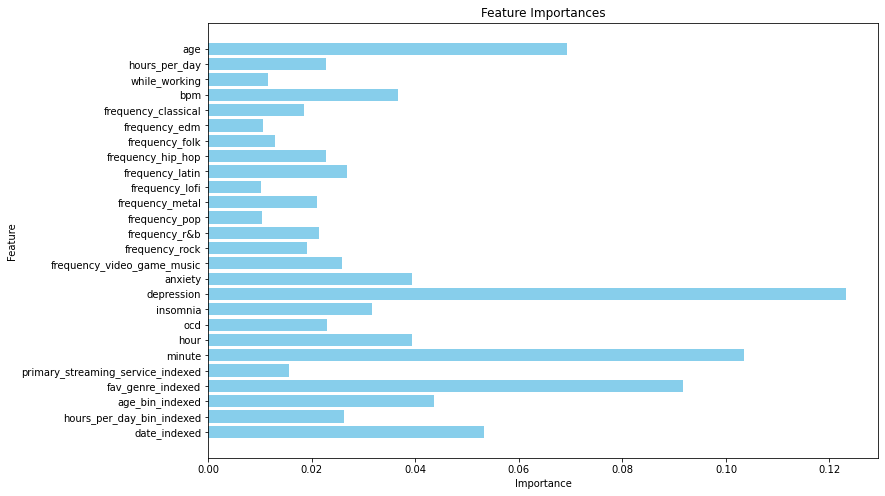

In [28]:
# Define a RandomForest model
rf = RandomForestClassifier(labelCol="music_effects", featuresCol="features", numTrees=100, maxBins=50)

# Train the model
rf_model = rf.fit(assembled_train_df)

# Get feature importances
importances = rf_model.featureImportances

# Get feature names
feature_names = assembler.getInputCols()

# Combine feature names and importances into a list of tuples, converting importances to float
data = [(feature, float(importance)) for feature, importance in zip(feature_names, importances.toArray())]

# Create a PySpark DataFrame
importance_df = spark.createDataFrame(data, ["Feature", "Importance"])

# Filter features with importance greater than 0.01
important_features_df = importance_df.filter(col("Importance") > 0.01)

# Show the information on the new dataset
important_features_df.show()

# Print schema to understand the structure
important_features_df.printSchema()


print(important_features)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(important_features["Feature"], important_features["Importance"], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


In [32]:
# Extracted features into new dataframe 
# List of important features to extract
important_features = [
    "age", "hours_per_day", "while_working", "bpm", "frequency_classical",
    "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin",
    "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b",
    "frequency_rock", "frequency_video_game_music", "anxiety", "depression",
    "insomnia", "ocd", "hour", "minute", "primary_streaming_service",
    "fav_genre", "age_bin", "hours_per_day_bin", "date"
]

# Extract the important features from the original DataFrame
extracted_df = df.select(*important_features)

# Show the new DataFrame with the important features
extracted_df.show()

# Print schema to understand the structure
extracted_df.printSchema()

+---+-------------+-------------+-----+-------------------+-------------+--------------+-----------------+---------------+--------------+---------------+-------------+-------------+--------------+--------------------------+-------+----------+--------+---+----+------+-------------------------+----------------+-------+-----------------+----------+
|age|hours_per_day|while_working|  bpm|frequency_classical|frequency_edm|frequency_folk|frequency_hip_hop|frequency_latin|frequency_lofi|frequency_metal|frequency_pop|frequency_r&b|frequency_rock|frequency_video_game_music|anxiety|depression|insomnia|ocd|hour|minute|primary_streaming_service|       fav_genre|age_bin|hours_per_day_bin|      date|
+---+-------------+-------------+-----+-------------------+-------------+--------------+-----------------+---------------+--------------+---------------+-------------+-------------+--------------+--------------------------+-------+----------+--------+---+----+------+-------------------------+-----------

In [35]:
# Convert the PySpark DataFrame to a Pandas DataFrame
extracted_pd_df = extracted_df.toPandas()

# Calculate the number of null values in each column
null_counts = extracted_pd_df.isnull().sum()

# Print the number of null values in each column
print("Null values in each column:")
print(null_counts)

# Get a concise summary of the DataFrame, including non-null counts and data types
print("\nColumn information:")
extracted_pd_df.info()


Null values in each column:
age                           0
hours_per_day                 0
while_working                 0
bpm                           0
frequency_classical           0
frequency_edm                 0
frequency_folk                0
frequency_hip_hop             0
frequency_latin               0
frequency_lofi                0
frequency_metal               0
frequency_pop                 0
frequency_r&b                 0
frequency_rock                0
frequency_video_game_music    0
anxiety                       0
depression                    0
insomnia                      0
ocd                           0
hour                          0
minute                        0
primary_streaming_service     0
fav_genre                     0
age_bin                       0
hours_per_day_bin             0
date                          0
dtype: int64

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 26 columns):
 

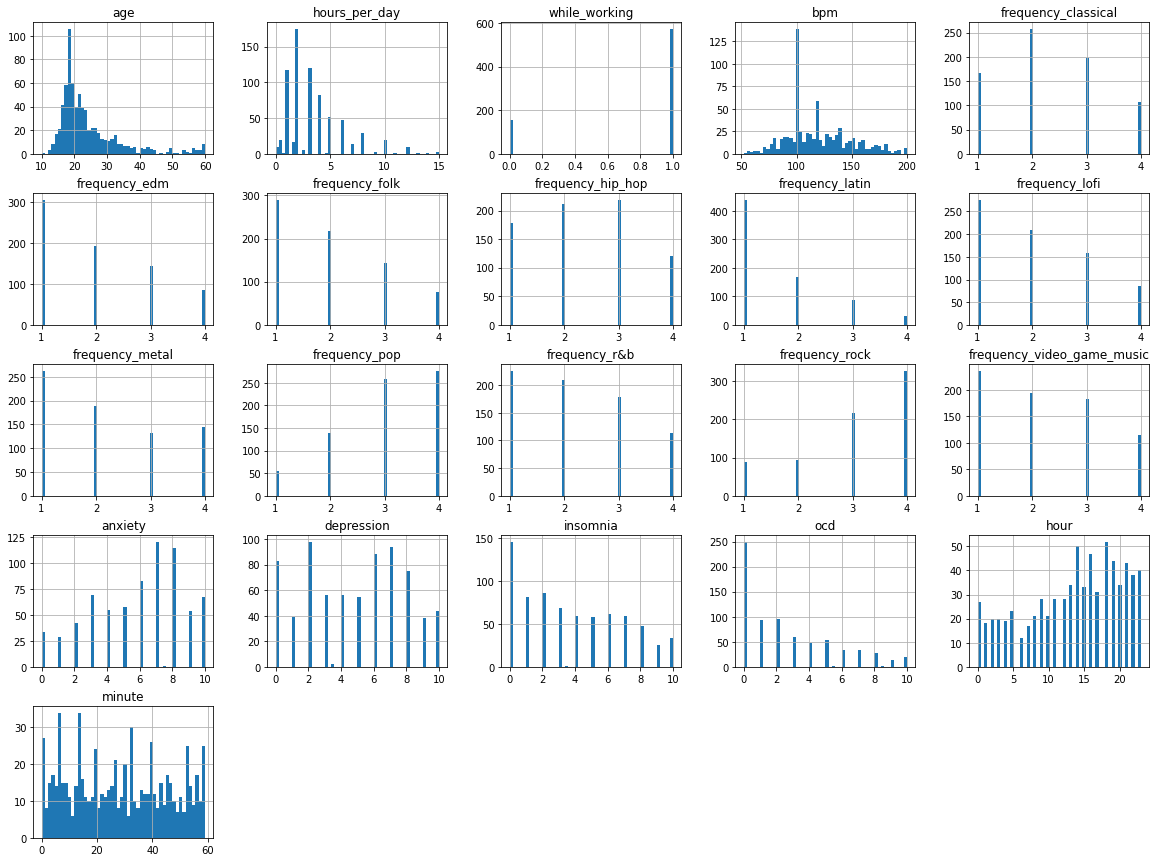

In [37]:
# Visualise distributions of selected features 
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
pandas_df = df.select(important_features).toPandas()

# Plot histograms of the features
pandas_df.hist(figsize=(20, 15), bins=50)
plt.show()


In [38]:
from pyspark.sql.functions import log, sqrt

# Apply log transformation
df_log_transformed = df.select(*[log(col(c) + 1).alias(f"{c}_log") for c in important_features if c not in ['hour', 'minute']])

# Apply square root transformation
df_sqrt_transformed = df.select(*[sqrt(col(c)).alias(f"{c}_sqrt") for c in important_features if c not in ['hour', 'minute']])


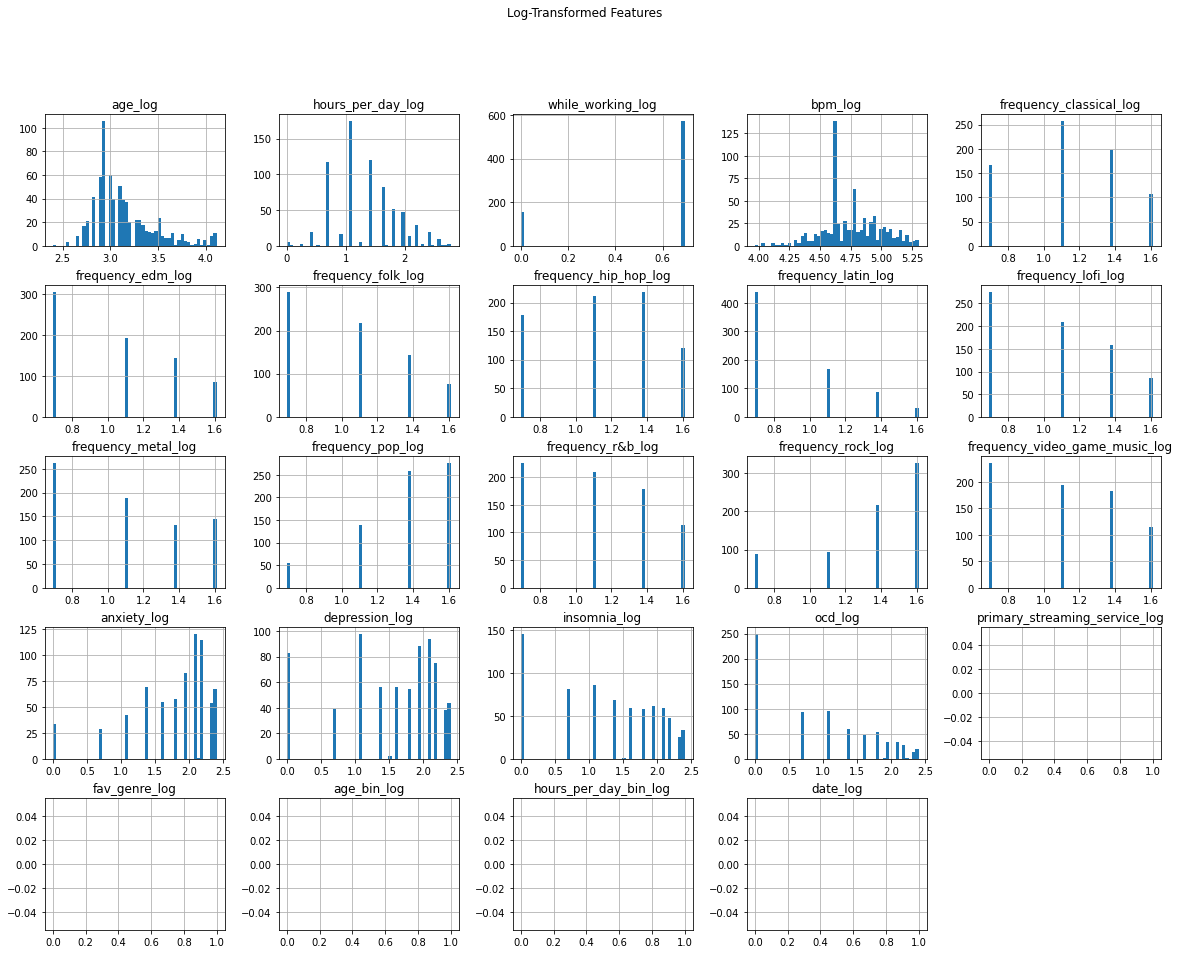

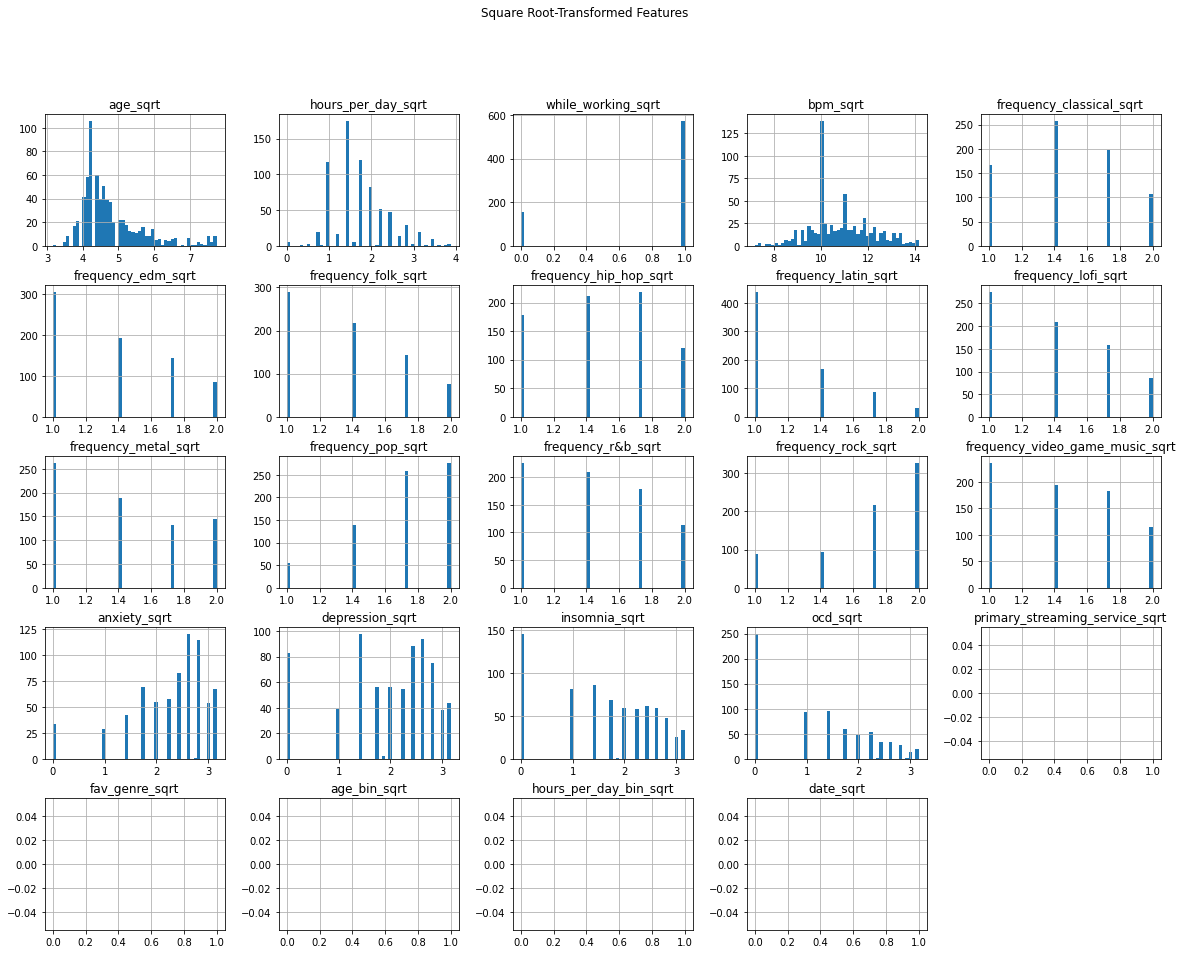

In [39]:
# Convert the transformed DataFrames to Pandas DataFrames
pandas_df_log = df_log_transformed.toPandas()
pandas_df_sqrt = df_sqrt_transformed.toPandas()

# Plot histograms of the log-transformed features
pandas_df_log.hist(figsize=(20, 15), bins=50)
plt.suptitle("Log-Transformed Features")
plt.show()

# Plot histograms of the square root-transformed features
pandas_df_sqrt.hist(figsize=(20, 15), bins=50)
plt.suptitle("Square Root-Transformed Features")
plt.show()


In [54]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, log, sqrt
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder.appName("FeatureSelection").getOrCreate()

# Assuming 'extracted_df' is your DataFrame with all necessary columns
df = extracted_df

# List of string columns to be indexed
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']

# Initialize StringIndexer for each string column with handleInvalid='keep'
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Apply StringIndexer to transform string columns into indexed columns
pipeline_indexer = Pipeline(stages=indexers)
df_indexed = pipeline_indexer.fit(df).transform(df)

# Ensure all columns are correctly transformed
def transform_columns(df, transformation_func, suffix):
    transformed_cols = [transformation_func(col(c)).alias(f"{c}_{suffix}") for c in df.columns if c not in string_cols + ['music_effects']]
    return df.select(['music_effects'] + [f"{col}_indexed" for col in string_cols] + transformed_cols)

# Apply log and sqrt transformations
df_log_transformed = transform_columns(df_indexed, lambda c: log(c + 1), 'log')
df_sqrt_transformed = transform_columns(df_indexed, sqrt, 'sqrt')

# Split data into training and testing sets
train_df, test_df = df_indexed.randomSplit([0.8, 0.2], seed=42)
train_log_df, test_log_df = df_log_transformed.randomSplit([0.8, 0.2], seed=42)
train_sqrt_df, test_sqrt_df = df_sqrt_transformed.randomSplit([0.8, 0.2], seed=42)

# Visualize distributions before and after transformations
def plot_distributions(original_df, transformed_df, transformation_name):
    for column in original_df.columns:
        if column not in string_cols + ['music_effects']:
            original_col_data = original_df.select(col(column)).toPandas()
            transformed_col_name = f"{column}_{transformation_name}"
            if transformed_col_name in transformed_df.columns:
                transformed_col_data = transformed_df.select(col(transformed_col_name)).toPandas()
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                sns.histplot(original_col_data, kde=True)
                plt.title(f'Original: {column}')
                plt.subplot(1, 2, 2)
                sns.histplot(transformed_col_data, kde=True)
                plt.title(f'{transformation_name}: {column}')
                plt.show()

# Evaluate additional metrics
def evaluate_model(predictions, evaluator):
    metrics = ['accuracy', 'weightedPrecision', 'weightedRecall', 'f1']
    for metric in metrics:
        score = evaluator.evaluate(predictions, {evaluator.metricName: metric})
        print(f'{metric}: {score}')

# List columns in transformed DataFrames
print("Log-Transformed DataFrame Columns:", df_log_transformed.columns)
print("Square Root-Transformed DataFrame Columns:", df_sqrt_transformed.columns)

# Plot distributions
plot_distributions(df_indexed, df_log_transformed, 'log')
plot_distributions(df_indexed, df_sqrt_transformed, 'sqrt')

# Assemble features for the original dataset
assembler = VectorAssembler(
    inputCols=[col for col in df_indexed.columns if col not in ['music_effects']] + [f"{col}_indexed" for col in string_cols],
    outputCol="features"
)

# Initialize the RandomForest model
rf = RandomForestClassifier(labelCol="music_effects", featuresCol="features", numTrees=100, maxBins=50)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Create a ParamGridBuilder
paramGrid = ParamGridBuilder().build()

# Initialize CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="music_effects", metricName="f1"),
                          numFolds=5)

# Fit the model on the original dataset
cvModel = crossval.fit(train_df)
predictions = cvModel.transform(test_df)

# Evaluate model performance with additional metrics
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction")
print("Original Data Metrics:")
evaluate_model(predictions, evaluator)

# Repeat the process for log-transformed dataset
assembler_log = VectorAssembler(
    inputCols=[f"{col}_log" for col in df.columns if col not in string_cols + ['music_effects']] + [f"{col}_indexed" for col in string_cols],
    outputCol="features"
)
pipeline_log = Pipeline(stages=[assembler_log, rf])
crossval_log = CrossValidator(estimator=pipeline_log,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(labelCol="music_effects", metricName="f1"),
                              numFolds=5)
cvModel_log = crossval_log.fit(train_log_df)
predictions_log = cvModel_log.transform(test_log_df)
print("Log-Transformed Data Metrics:")
evaluate_model(predictions_log, evaluator)

# Repeat the process for square root-transformed dataset
assembler_sqrt = VectorAssembler(
    inputCols=[f"{col}_sqrt" for col in df.columns if col not in string_cols + ['music_effects']] + [f"{col}_indexed" for col in string_cols],
    outputCol="features"
)
pipeline_sqrt = Pipeline(stages=[assembler_sqrt, rf])
crossval_sqrt = CrossValidator(estimator=pipeline_sqrt,
                               estimatorParamMaps=paramGrid,
                               evaluator=MulticlassClassificationEvaluator(labelCol="music_effects", metricName="f1"),
                               numFolds=5)
cvModel_sqrt = crossval_sqrt.fit(train_sqrt_df)
predictions_sqrt = cvModel_sqrt.transform(test_sqrt_df)
print("Square Root-Transformed Data Metrics:")
evaluate_model(predictions_sqrt, evaluator)


AnalysisException: cannot resolve 'music_effects' given input columns: [age, age_bin, age_bin_indexed, anxiety, bpm, date, date_indexed, depression, fav_genre, fav_genre_indexed, frequency_classical, frequency_edm, frequency_folk, frequency_hip_hop, frequency_latin, frequency_lofi, frequency_metal, frequency_pop, frequency_r&b, frequency_rock, frequency_video_game_music, hour, hours_per_day, hours_per_day_bin, hours_per_day_bin_indexed, insomnia, minute, ocd, primary_streaming_service, primary_streaming_service_indexed, while_working];
'Project ['music_effects, primary_streaming_service_indexed#296477, fav_genre_indexed#296511, age_bin_indexed#296546, hours_per_day_bin_indexed#296582, date_indexed#296619, ln(cast((age#5303 + 1) as double)) AS age_log#296654, ln((hours_per_day#5305 + cast(1 as double))) AS hours_per_day_log#296655, ln(cast((while_working#5306 + 1) as double)) AS while_working_log#296656, ln((bpm#5312 + cast(1 as double))) AS bpm_log#296657, ln(cast((frequency_classical#5313 + 1) as double)) AS frequency_classical_log#296658, ln(cast((frequency_edm#5315 + 1) as double)) AS frequency_edm_log#296659, ln(cast((frequency_folk#5316 + 1) as double)) AS frequency_folk_log#296660, ln(cast((frequency_hip_hop#5318 + 1) as double)) AS frequency_hip_hop_log#296661, ln(cast((frequency_latin#5321 + 1) as double)) AS frequency_latin_log#296662, ln(cast((frequency_lofi#5322 + 1) as double)) AS frequency_lofi_log#296663, ln(cast((frequency_metal#5323 + 1) as double)) AS frequency_metal_log#296664, ln(cast((frequency_pop#5324 + 1) as double)) AS frequency_pop_log#296665, ln(cast((frequency_r&b#5325 + 1) as double)) AS frequency_r&b_log#296666, ln(cast((frequency_rock#5327 + 1) as double)) AS frequency_rock_log#296667, ln(cast((frequency_video_game_music#5328 + 1) as double)) AS frequency_video_game_music_log#296668, ln((anxiety#5329 + cast(1 as double))) AS anxiety_log#296669, ln((depression#5330 + cast(1 as double))) AS depression_log#296670, ln((insomnia#5331 + cast(1 as double))) AS insomnia_log#296671, ... 8 more fields]
+- Project [age#5303, hours_per_day#5305, while_working#5306, bpm#5312, frequency_classical#5313, frequency_edm#5315, frequency_folk#5316, frequency_hip_hop#5318, frequency_latin#5321, frequency_lofi#5322, frequency_metal#5323, frequency_pop#5324, frequency_r&b#5325, frequency_rock#5327, frequency_video_game_music#5328, anxiety#5329, depression#5330, insomnia#5331, ocd#5332, hour#5337, minute#5338, primary_streaming_service#5304, fav_genre#5309, age_bin#5334, ... 7 more fields]
   +- Project [age#5303, hours_per_day#5305, while_working#5306, bpm#5312, frequency_classical#5313, frequency_edm#5315, frequency_folk#5316, frequency_hip_hop#5318, frequency_latin#5321, frequency_lofi#5322, frequency_metal#5323, frequency_pop#5324, frequency_r&b#5325, frequency_rock#5327, frequency_video_game_music#5328, anxiety#5329, depression#5330, insomnia#5331, ocd#5332, hour#5337, minute#5338, primary_streaming_service#5304, fav_genre#5309, age_bin#5334, ... 6 more fields]
      +- Project [age#5303, hours_per_day#5305, while_working#5306, bpm#5312, frequency_classical#5313, frequency_edm#5315, frequency_folk#5316, frequency_hip_hop#5318, frequency_latin#5321, frequency_lofi#5322, frequency_metal#5323, frequency_pop#5324, frequency_r&b#5325, frequency_rock#5327, frequency_video_game_music#5328, anxiety#5329, depression#5330, insomnia#5331, ocd#5332, hour#5337, minute#5338, primary_streaming_service#5304, fav_genre#5309, age_bin#5334, ... 5 more fields]
         +- Project [age#5303, hours_per_day#5305, while_working#5306, bpm#5312, frequency_classical#5313, frequency_edm#5315, frequency_folk#5316, frequency_hip_hop#5318, frequency_latin#5321, frequency_lofi#5322, frequency_metal#5323, frequency_pop#5324, frequency_r&b#5325, frequency_rock#5327, frequency_video_game_music#5328, anxiety#5329, depression#5330, insomnia#5331, ocd#5332, hour#5337, minute#5338, primary_streaming_service#5304, fav_genre#5309, age_bin#5334, ... 4 more fields]
            +- Project [age#5303, hours_per_day#5305, while_working#5306, bpm#5312, frequency_classical#5313, frequency_edm#5315, frequency_folk#5316, frequency_hip_hop#5318, frequency_latin#5321, frequency_lofi#5322, frequency_metal#5323, frequency_pop#5324, frequency_r&b#5325, frequency_rock#5327, frequency_video_game_music#5328, anxiety#5329, depression#5330, insomnia#5331, ocd#5332, hour#5337, minute#5338, primary_streaming_service#5304, fav_genre#5309, age_bin#5334, ... 3 more fields]
               +- Project [age#5303, hours_per_day#5305, while_working#5306, bpm#5312, frequency_classical#5313, frequency_edm#5315, frequency_folk#5316, frequency_hip_hop#5318, frequency_latin#5321, frequency_lofi#5322, frequency_metal#5323, frequency_pop#5324, frequency_r&b#5325, frequency_rock#5327, frequency_video_game_music#5328, anxiety#5329, depression#5330, insomnia#5331, ocd#5332, hour#5337, minute#5338, primary_streaming_service#5304, fav_genre#5309, age_bin#5334, ... 2 more fields]
                  +- Relation [unique_id#5302,age#5303,primary_streaming_service#5304,hours_per_day#5305,while_working#5306,instrumentalist#5307,composer#5308,fav_genre#5309,exploratory#5310,foreign_languages#5311,bpm#5312,frequency_classical#5313,frequency_country#5314,frequency_edm#5315,frequency_folk#5316,frequency_gospel#5317,frequency_hip_hop#5318,frequency_jazz#5319,frequency_k_pop#5320,frequency_latin#5321,frequency_lofi#5322,frequency_metal#5323,frequency_pop#5324,frequency_r&b#5325,... 13 more fields] csv
